**Introdução a Redes Neurais Artificiais com Keras**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/fabiobento/dnn-course-2025-1/blob/main/nn-intro/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/fabiobento/dnn-course-2025-1/blob/main/nn-intro/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Configuração

Este projeto requer Python 3.7 ou superior:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Também requer Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

E TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2025-02-25 17:06:51.736028: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 17:06:51.745402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-25 17:06:51.758802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-25 17:06:51.758830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 17:06:51.767919: I tensorflow/core/platform/cpu_feature_gua

Vamos definir os tamanhos de fonte padrão para melhorar as figuras:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

E vamos criar a pasta `images/ann` (se ela ainda não existir) e definir a função `save_fig()` que é usada nesse notebook para salvar as figuras em alta resolução:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dos neurônios biológicos aos artificiais
## O Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  #  prevê Verdadeiro e Falso para essas 2 flores

In [7]:
y_pred

array([ True, False])

O `Perceptron` é equivalente a um `SGDClassifier` com `loss=“perceptron”`, sem regularização e com uma taxa de aprendizado constante igual a 1:

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

Quando o Perceptron encontra um limite de decisão que separa corretamente as classes, ele interrompe o aprendizado.

Isso significa que o limite de decisão geralmente está muito próximo de uma classe:

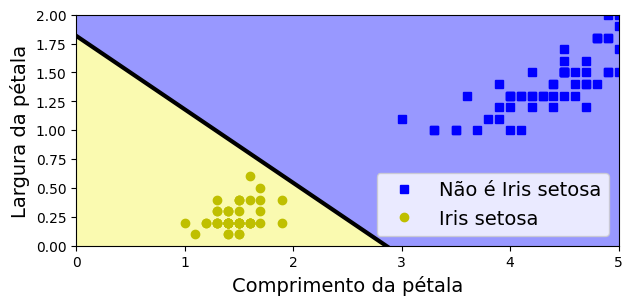

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Não é Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Comprimento da pétala")
plt.ylabel("Largura da pétala")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Funções de Ativação**

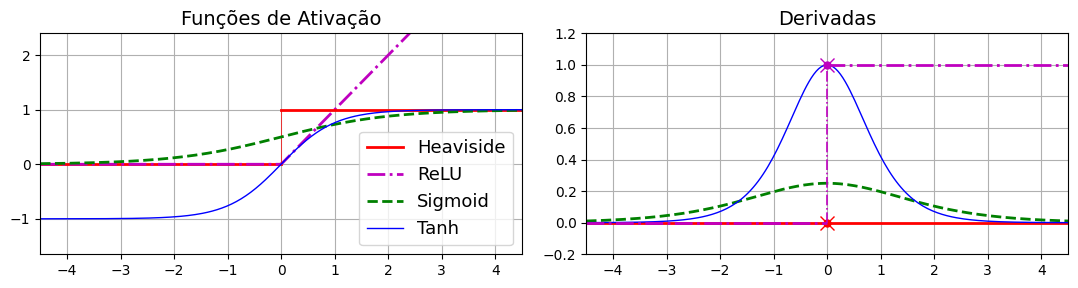

In [10]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Funções de Ativação")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivadas")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## MLPs para regressão

In [11]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
#rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse = mean_squared_error(y_valid, y_pred) ** 0.5  
# ou
# rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

In [12]:
rmse

0.5053326657968698

## MLPs de classificação

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementação de MLPs com o Keras
## Criando um classificador de imagem usando a API sequencial
### Usando o Keras para carregar o conjunto de dados

Vamos começar carregando o conjunto de dados fashion MNIST.

O Keras tem várias funções para carregar conjuntos de dados populares em `tf.keras.datasets`.

O conjunto de dados já está dividido para você entre um conjunto de treinamento (60.000 imagens) e um conjunto de teste (10.000 imagens), mas pode ser útil dividir ainda mais o conjunto de treinamento para ter um conjunto de validação.

Usaremos 55.000 imagens para treinamento e 5.000 para validação.

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

O conjunto de treinamento contém **60.000** imagens em escala de cinza, cada uma com **28x28** pixels:

In [15]:
X_train.shape

(55000, 28, 28)

In [16]:
X_valid.shape

(5000, 28, 28)

A intensidade de cada pixel é representada como um byte (0 a 255):

In [17]:
X_train.dtype

dtype('uint8')

Vamos reduzir as intensidades de pixel para o intervalo 0-1 e convertê-las em floats, dividindo-as por 255:

In [18]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Você pode plotar uma imagem usando a função `imshow()` do Matplotlib, com um mapa de cores `'binary'`:

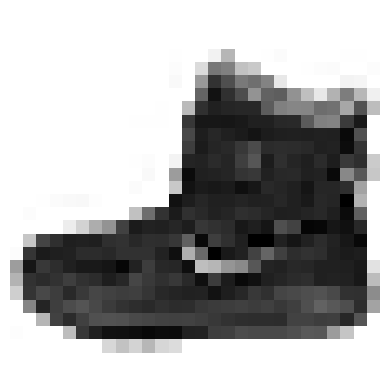

In [19]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Os rótulos são os IDs de classe (representados como uint8), de 0 a 9:

In [20]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Aqui estão os nomes das classes correspondentes:

In [21]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Portanto, a primeira imagem no conjunto de treinamento é uma:

In [22]:
class_names[y_train[0]]

'Ankle boot'

Vamos dar uma olhada em uma amostra das imagens do conjunto de dados:

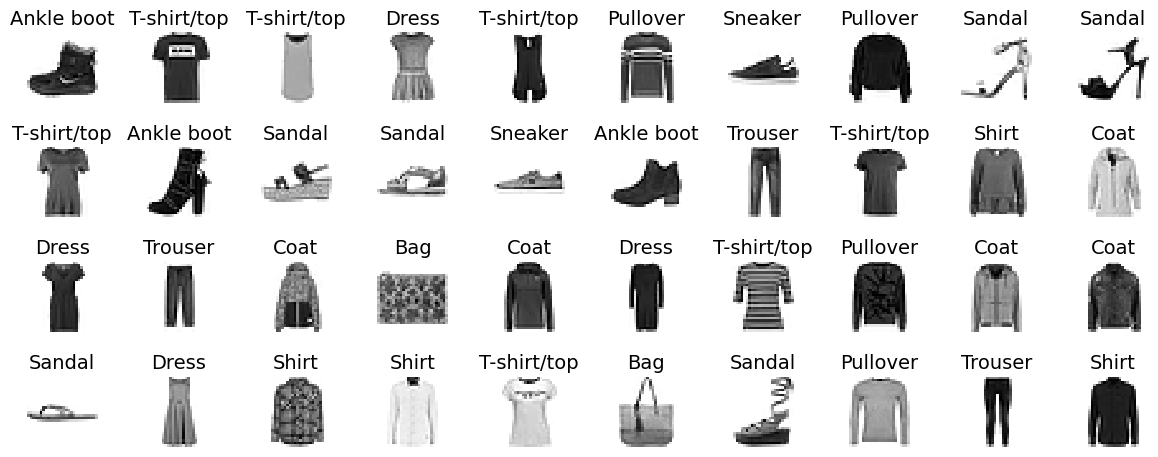

In [23]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Criando o modelo usando a API sequencial

In [24]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/home/fabio/anaconda3/envs/homl3-gpu/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-02-25 17:07:02.814904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-25 17:07:02.853060: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-25 17:07:02.855668: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS h

In [25]:
#  código extra - limpar a sessão para redefinir os contadores de nomes
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/home/fabio/anaconda3/envs/homl3-gpu/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

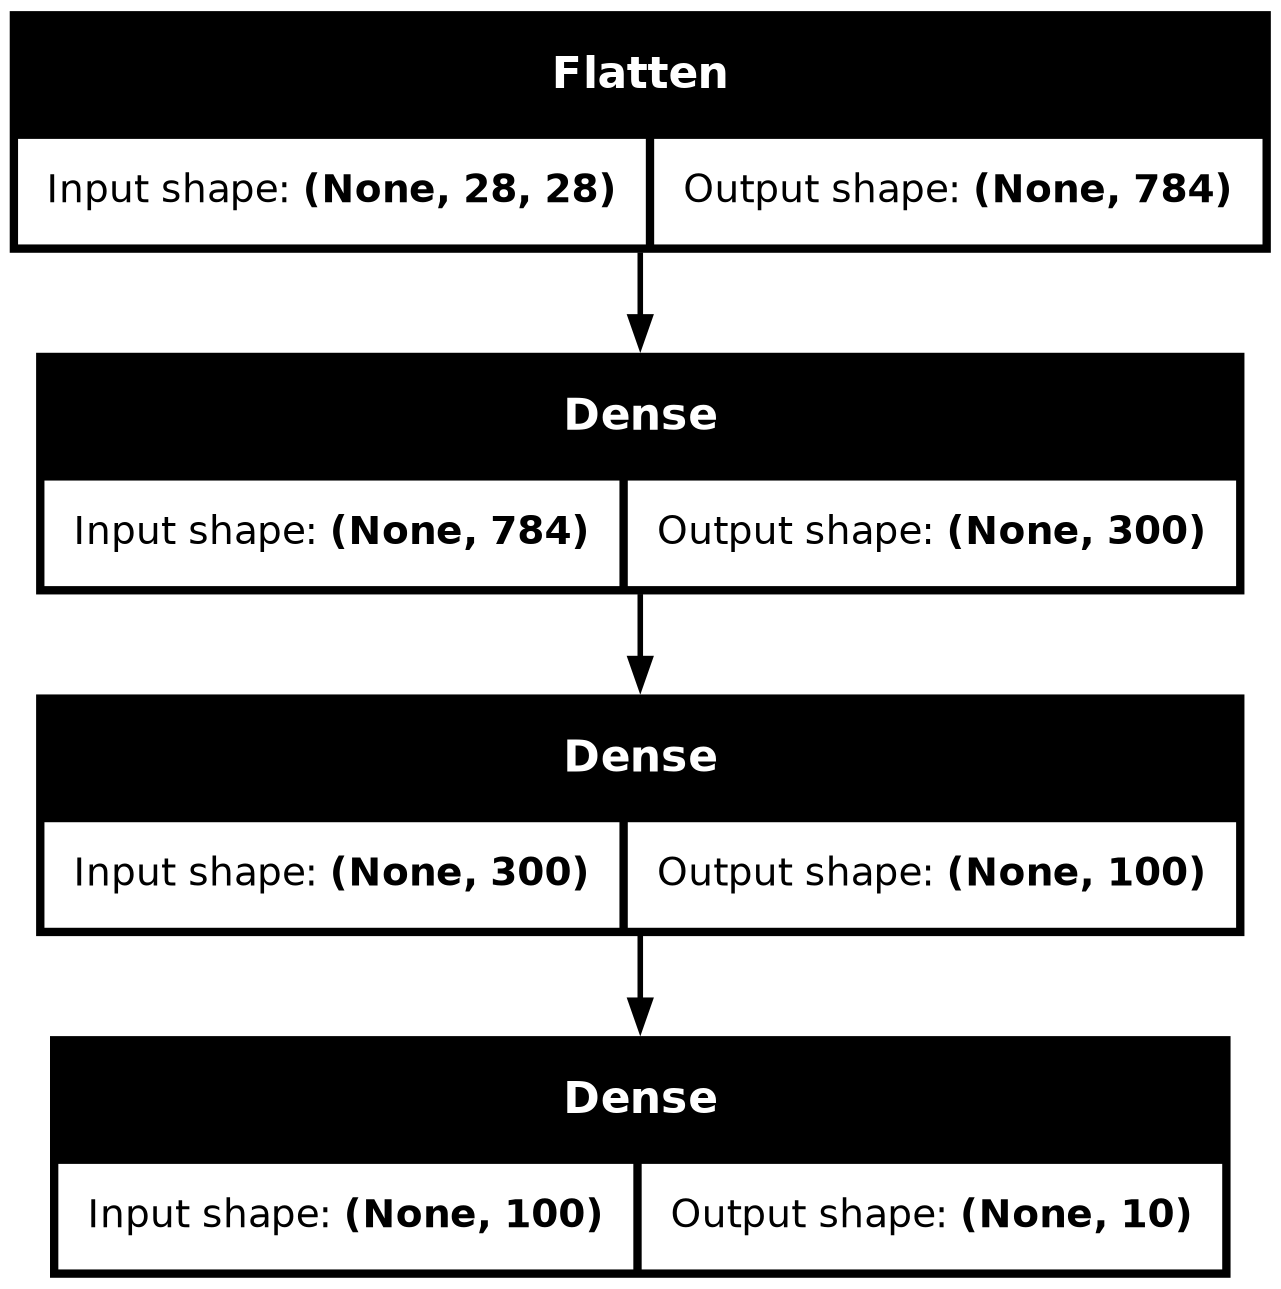

In [27]:
# outra maneira de exibir a arquitetura do modelo
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [28]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [29]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [30]:
model.get_layer('dense') is hidden1

True

In [31]:
weights, biases = hidden1.get_weights()
weights

array([[-0.05238763, -0.02580335,  0.00211364, ..., -0.07282762,
         0.02870471, -0.00095391],
       [-0.02815512,  0.01294741,  0.02211701, ...,  0.01823982,
         0.06678146, -0.0067862 ],
       [ 0.06052408, -0.01160155,  0.01511452, ...,  0.01116157,
         0.04283044, -0.04315418],
       ...,
       [-0.03344442,  0.02954766, -0.00526576, ..., -0.0682647 ,
         0.04769342,  0.05648288],
       [ 0.04854813, -0.05223567, -0.00537948, ..., -0.0582772 ,
         0.06443332,  0.04887041],
       [-0.03206759, -0.03517725, -0.06747927, ..., -0.06726916,
        -0.04861357, -0.03623893]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape

(300,)

### Compilando o modelo

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Isso é equivalente a:

In [36]:
# código extra - esta célula é equivalente à célula anterior
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [37]:
# código extra - mostra como converter ids de classe em vetores one-hot
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Observação: é importante definir `num_classes` quando o número de classes for maior do que o ID máximo da classe na amostra.

In [38]:
# Código extra - mostra como converter vetores one-hot em IDs de classe
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Treinando e avaliando o modelo

In [39]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30


I0000 00:00:1740514024.081141  178456 service.cc:145] XLA service 0x753154005290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740514024.081164  178456 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-02-25 17:07:04.088196: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-25 17:07:04.129914: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1740514024.393507  178539 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1740514024.626670  178551 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_189', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:174

 186/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - loss: 1.7872 - sparse_categorical_accuracy: 0.4243

I0000 00:00:1740514025.602262  178456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1668/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 1.0168 - sparse_categorical_accuracy: 0.6688

I0000 00:00:1740514027.499418  178635 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_189', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1740514027.721791  178636 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_189', 56 bytes spill stores, 56 bytes spill loads



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.0081 - sparse_categorical_accuracy: 0.6714 - val_loss: 0.5150 - val_sparse_categorical_accuracy: 0.8202
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - loss: 0.5136 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.4604 - val_sparse_categorical_accuracy: 0.8358
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step - loss: 0.4568 - sparse_categorical_accuracy: 0.8425 - val_loss: 0.4349 - val_sparse_categorical_accuracy: 0.8430
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 890us/step - loss: 0.4258 - sparse_categorical_accuracy: 0.8520 - val_loss: 0.4177 - val_sparse_categorical_accuracy: 0.8484
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - loss: 0.4038 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.4054 - val_sparse_categorical_accuracy: 0.8534
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 897us/step - loss: 0.3864 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.3935 - val_sparse_categorical_accuracy: 

In [40]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [41]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


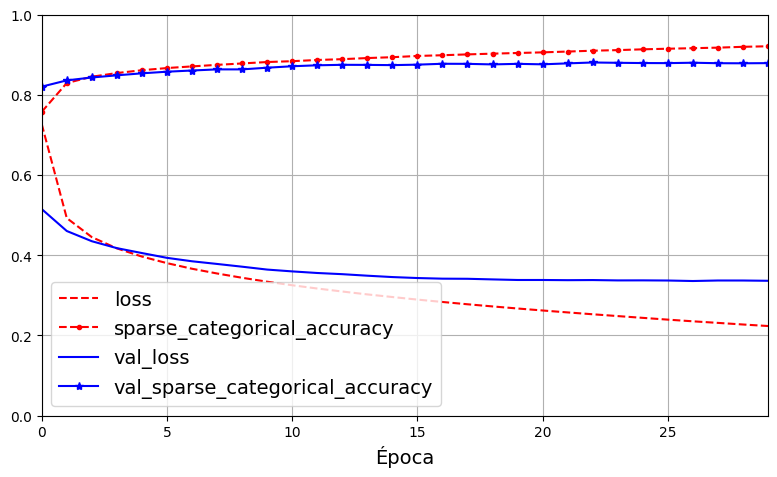

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Época",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # código extra
save_fig("keras_learning_curves_plot")  # código extra
plt.show()

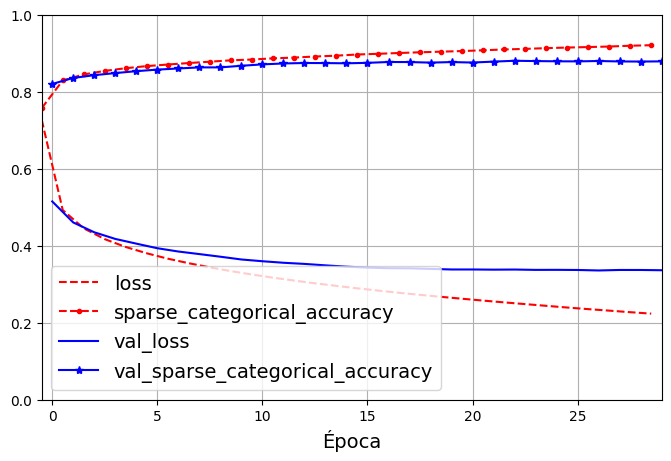

In [43]:
# Código extra - mostra como deslocar a curva de treinamento em -1 a cada 2 épocas
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Época")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [44]:
model.evaluate(X_test, y_test)

279/313 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 0.3592 - sparse_categorical_accuracy: 0.8761

I0000 00:00:1740514078.411564  181227 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_36', 4 bytes spill stores, 4 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3591 - sparse_categorical_accuracy: 0.8760 


[0.35584983229637146, 0.8762999773025513]

### Usando o modelo para fazer previsões

In [45]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 715ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.39, 0.  , 0.01, 0.  , 0.6 ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [46]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [47]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [48]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

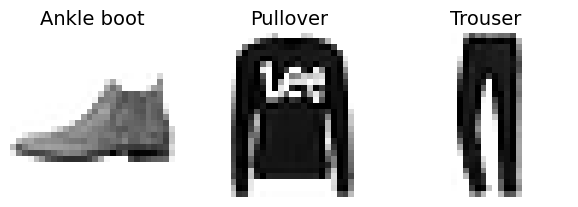

In [49]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Criando um MLP de regressão usando a API sequencial

Vamos carregar, dividir e dimensionar o conjunto de dados de moradias da Califórnia:

In [50]:
# Código extra - carregar e dividir o California housing dataset, como anteriormente
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [51]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


/home/fabio/anaconda3/envs/homl3-gpu/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 1.0992 - loss: 1.2723 - val_RootMeanSquaredError: 0.6077 - val_loss: 0.3693
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6244 - loss: 0.3903 - val_RootMeanSquaredError: 0.5926 - val_loss: 0.3512
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5978 - loss: 0.3576 - val_RootMeanSquaredError: 0.5955 - val_loss: 0.3547
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5856 - loss: 0.3430 - val_RootMeanSquaredError: 0.6015 - val_loss: 0.3618
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5765 - loss: 0.3325 - val_RootMeanSquaredError: 0.5618 - val_loss: 0.3156
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5695 - loss: 0.3245 - val_RootMeanSquaredError: 0.6556 - val_loss: 0.4298
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5634 - loss: 0.3175 -

In [52]:
rmse_test

0.537309467792511

In [53]:
y_pred

array([[0.57030463],
       [1.1145027 ],
       [4.972371  ]], dtype=float32)

## Criação de modelos complexos usando a API funcional

Nem todos os modelos de redes neurais são simplesmente sequenciais:
- Alguns podem ter topologias complexas.
- Alguns podem ter várias entradas e/ou várias saídas.

Um exemplo de rede neural não sequencial é a rede neural ampla e profunda (_wide and deep_) da Figura 10-13 abaixo.

- Essa arquitetura de rede neural foi apresentada em um [artigo de 2016 por Heng-Tze Cheng et al](https://dl.acm.org/doi/abs/10.1145/2988450.2988454).

- Ela conecta todas ou parte das entradas diretamente à camada de saída, conforme mostrado na Figura 10-13.

- Essa arquitetura permite que a rede neural aprenda tanto padrões profundos (usando o caminho profundo) quanto 
regras simples (por meio do caminho curto).

- Por outro lado, um MLP regular força todos os dados a fluir por toda a pilha de camadas; assim, padrões simples nos dados podem acabar sendo distorcidos por essa sequência de transformações.

![image](https://github.com/fabiobento/dnn-course-2025-1/raw/main/nn-intro/images/wide_deep.png)

[Figura do livro "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" de A. Géron(2022).]



In [54]:
# Código extra - redefine os contadores de nomes e torna o código reproduzível
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [55]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [56]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20


/home/fabio/anaconda3/envs/homl3-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 8))
  warnings.warn(msg)


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - RootMeanSquaredError: 1.4425 - loss: 2.2101 - val_RootMeanSquaredError: 1.1315 - val_loss: 1.2803
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.7440 - loss: 0.5554 - val_RootMeanSquaredError: 0.6874 - val_loss: 0.4725
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6642 - loss: 0.4415 - val_RootMeanSquaredError: 1.3604 - val_loss: 1.8508
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6326 - loss: 0.4005 - val_RootMeanSquaredError: 1.1328 - val_loss: 1.2833
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6184 - loss: 0.3825 - val_RootMeanSquaredError: 1.3789 - val_loss: 1.9013
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6096 - loss: 0.3717 - val_RootMeanSquaredError: 1.2046 - val_loss: 1.4511
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.6047 - loss: 0.3658 -

/home/fabio/anaconda3/envs/homl3-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3, 8))
  warnings.warn(msg)


E se você quiser enviar diferentes subconjuntos de recursos de entrada por meio dos caminhos largo ou profundo?

Enviaremos 5 recursos (recursos 0 a 4) pelo camonho largo e 6 pelo caminho profundo (recursos 2 a 7).

Observe que 3 recursos passarão por ambos (recursos 2, 3 e 4).

In [58]:
tf.random.set_seed(42)  # código extra

In [59]:
input_wide = tf.keras.layers.Input(shape=[5])  # recursos 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # recursos 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()

norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - RootMeanSquaredError: 1.7220 - loss: 3.0768 - val_RootMeanSquaredError: 0.9411 - val_loss: 0.8856
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.8061 - loss: 0.6504 - val_RootMeanSquaredError: 0.7313 - val_loss: 0.5349
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7210 - loss: 0.5201 - val_RootMeanSquaredError: 1.3771 - val_loss: 1.8965
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6717 - loss: 0.4514 - val_RootMeanSquaredError: 1.2528 - val_loss: 1.5696
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6384 - loss: 0.4077 - val_RootMeanSquaredError: 1.0047 - val_loss: 1.0094
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6161 - loss: 0.3796 - val_RootMeanSquaredError: 0.7909 - val_loss: 0.6255
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.6045 - los

Há também vários casos de uso em que você pode querer ter várias saídas:

- A tarefa pode exigir isso. Por exemplo, talvez você queira localizar e classificar o objeto principal em uma imagem. Isso é tanto uma tarefa de regressão quanto uma tarefa de classificação.

- Da mesma forma, você pode ter várias tarefas independentes com base nos mesmos dados. É claro que você poderia treinar uma rede neural por tarefa, mas, em muitos casos, obterá melhores resultados em todas as tarefas treinando uma única rede neural com uma saída por tarefa. Isso ocorre porque a rede neural pode aprender recursos nos dados que são úteis em todas as tarefas. Por exemplo, você pode executar a classificação multitarefa em imagens de rostos, usando uma saída para classificar a expressão facial da pessoa (sorrindo, surpresa etc.) e outra saída para identificar se ela está usando óculos ou não.

- Outro caso de uso para utilizar um modelo com múltiplas entrada e multiplias saídas é uma técnica de regularização (ou seja, uma restrição de treinamento cujo objetivo é reduzir o excesso de ajuste e, assim, melhorar a capacidade de generalização do modelo).

    - Por exemplo, talvez você queira adicionar uma saída auxiliar em uma arquitetura de rede neural (consulte a Figura 10-15) para garantir que a parte subjacente da rede aprenda algo útil por conta própria, sem depender do restante da rede.
![image](https://github.com/fabiobento/dnn-course-2025-1/raw/main/nn-intro/images/wide_deep_mult_output.png)

[Figura do livro "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" de A. Géron(2022).]

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [62]:
# Adição de uma saída auxiliar para regularização:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1, name="main_output")(concat)
aux_output = tf.keras.layers.Dense(1, name="aux_output")(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

Cada saída precisará de sua própria função de perda.

- Portanto, quando compilamos o modelo, devemos passar uma lista de perdas.

- Se passarmos uma única perda, o Keras assumirá que a mesma perda deve ser usada para todas as saídas.

- Por padrão, o Keras calculará todas as perdas e simplesmente as adicionará para obter a perda final usada no treinamento.

- Como nos preocupamos muito mais com a saída principal do que com a saída auxiliar (já que ela é usada apenas para regularização), queremos dar à perda da saída principal um peso muito maior.
    - Felizmente, é possível definir todos os pesos de perda ao compilar o modelo com `loss_weights`:

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError","RootMeanSquaredError"])

- Agora, quando treinarmos o modelo, precisaremos fornecer rótulos para cada saída.

- Neste exemplo, a saída principal e a saída auxiliar devem tentar prever a mesma coisa, portanto, devem usar os mesmos rótulos.

In [64]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - aux_output_RootMeanSquaredError: 1.8053 - aux_output_loss: 3.3169 - loss: 2.1412 - main_output_RootMeanSquaredError: 1.3888 - main_output_loss: 2.0105 - val_aux_output_RootMeanSquaredError: 2.1862 - val_aux_output_loss: 4.7775 - val_loss: 0.9480 - val_main_output_RootMeanSquaredError: 0.7227 - val_main_output_loss: 0.5222
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - aux_output_RootMeanSquaredError: 0.9686 - aux_output_loss: 0.9397 - loss: 0.5582 - main_output_RootMeanSquaredError: 0.7178 - main_output_loss: 0.5159 - val_aux_output_RootMeanSquaredError: 1.1254 - val_aux_output_loss: 1.2662 - val_loss: 0.5076 - val_main_output_RootMeanSquaredError: 0.6506 - val_main_output_loss: 0.4232
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_RootMeanSquaredError: 0.8053 - aux_output_loss: 0.6488 - loss: 0.4691 - main_output_RootMeanSquaredError: 0.6700 - main_output_loss: 0.4491 - val_aux_output_RootMeanSquaredError: 

In [65]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))

# Desempacotando os valores retornados
weighted_sum_of_losses = eval_results[0]  # Perda total ponderada
main_loss = eval_results[1]  # Perda principal
aux_loss = eval_results[2]  # Perda auxiliar

# As métricas começam a partir do índice 3
main_rmse = eval_results[3]  # RMSE da saída principal
aux_rmse = eval_results[4]  # RMSE da saída auxiliar

print(f"Perda ponderada: {weighted_sum_of_losses}")
print(f"Perda principal: {main_loss}, Main RMSE: {main_rmse}")
print(f"Perda auxiliar: {aux_loss}, Aux RMSE: {aux_rmse}")


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - aux_output_RootMeanSquaredError: 0.6298 - aux_output_loss: 0.3968 - loss: 0.3392 - main_output_RootMeanSquaredError: 0.5768 - main_output_loss: 0.3328 
Perda ponderada: 0.33429378271102905
Perda principal: 0.3274785876274109, Main RMSE: 0.6251702904701233
Perda auxiliar: 0.39061978459358215, Aux RMSE: 0.5727224349975586


In [66]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


In [67]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


## Usando a API de subclasses para criar modelos dinâmicos

- Tanto a API sequencial quanto a API funcional são declarativas:
    - você começa declarando quais camadas deseja usar e
    - como elas devem ser conectadas, e
    - só então pode começar a alimentar o modelo com alguns dados para treinamento ou inferência.
- Isso tem muitas vantagens:
    - o modelo pode ser facilmente salvo, clonado e compartilhado;
    - sua estrutura pode ser exibida e analisada;
    - o _framework_ pode inferir formas e verificar tipos, de modo que os erros podem ser detectados antecipadamente (ou seja, antes que qualquer dado passe pelo modelo).
    - Também é bastante simples de depurar, pois todo o modelo é um gráfico estático de camadas.
    
    - Mas o lado negativo é justamente esse: é estático.
        - Alguns modelos envolvem:
            - loops,
            - formas variáveis,
            - ramificação condicional e
            - outros comportamentos dinâmicos.
        - Para esses casos, ou simplesmente se você preferir um estilo de programação mais imperativo, a API de subclasses é para você.


In [68]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # necessário para dar suporte à nomeação do modelo
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # Código extra - apenas para reprodutibilidade
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

Aviso: em versões recentes, o Keras exige uma métrica por saída, por isso substituí metrics=[“RootMeanSquaredError”] por metrics=[“RootMeanSquaredError”, “RootMeanSquaredError”] no código abaixo.

In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError","RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - RootMeanSquaredError: 1.6161 - RootMeanSquaredError_1: 1.5200 - loss: 2.6670 - mse_loss: 2.3885 - val_RootMeanSquaredError: 0.8380 - val_RootMeanSquaredError_1: 0.8568 - val_loss: 0.7055 - val_mse_loss: 0.7339
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.8076 - RootMeanSquaredError_1: 0.8382 - loss: 0.6581 - mse_loss: 0.7033 - val_RootMeanSquaredError: 0.7966 - val_RootMeanSquaredError_1: 0.8064 - val_loss: 0.6362 - val_mse_loss: 0.6501
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7138 - RootMeanSquaredError_1: 0.7661 - loss: 0.5175 - mse_loss: 0.5871 - val_RootMeanSquaredError: 0.6599 - val_RootMeanSquaredError_1: 0.7310 - val_loss: 0.4453 - val_mse_loss: 0.5343
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.6662 - RootMeanSquaredError_1: 0.7286 - loss: 0.4528 - mse_loss: 0.5311 - val_RootMeanSquaredError: 0.6203 - val_RootMeanSquaredEr

## Salvando e restaurando um modelo

**Aviso**:
- O Keras agora recomenda o uso:
    - do formato `.keras` para salvar modelos e
    - o formato `h5` para pesos.
- Portanto, atualizei o código nesta seção para mostrar primeiro o que precisa ser alterado se ainda quiser usar o formato `SavedModel` do __TensorFlow__ e, em seguida, como usar os formatos recomendados.

In [70]:
# código extra - exclui o diretório, caso ele já exista

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

**Aviso**: O método `model.save()` do Keras não é mais compatível com o formato `SavedModel` do TensorFlow. No entanto, você ainda pode exportar modelos para o formato `SavedModel` usando `model.export()` desta forma:

In [71]:
model.export("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)]
Output Type:
  Tuple[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  128860692414880: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  128860692417520: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  128860692422272: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  128860691202464: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  128860691255840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128860692419280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128860691263232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128860691402064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  128860691254784: TensorSpec(shape=

In [72]:
# Código extra - mostra o conteúdo do diretório my_keras_model/
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


**Aviso**: No Keras 3, não é mais possível carregar um `SavedModel` do TensorFlow como um modelo do Keras. No entanto, você pode carregar um `SavedModel` como uma camada `tf.keras.layers.TFSMLayer`, mas esteja ciente de que essa camada só pode ser usada para inferência: nenhum treinamento.

In [73]:
tfsm_layer = tf.keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

**Aviso**: O Keras agora exige que os pesos salvos tenham a extensão `.weights.h5`. Eles não são mais salvos usando o formato `SavedModel`.

In [74]:
model.save_weights("my_weights.weights.h5")

In [75]:
model.load_weights("my_weights.weights.h5")

Para salvar um modelo usando o formato `.keras`, basta usar `model.save()`:

In [76]:
model.save("my_model.keras")

Para carregar um modelo `.keras`, use a função `tf.keras.models.load_model()`. Se o modelo usar algum objeto personalizado, você deverá passá-lo para a função por meio do argumento `custom_objects`:

In [77]:
loaded_model = tf.keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)

## Usando _Callbacks_

O método `fit()` aceita um argumento `callbacks` que permite especificar uma lista de objetos que o Keras chamará:
- antes e depois do treinamento,
- antes e depois de cada época e
- depois do processamento de cada lote.

In [78]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # código extra

**Aviso**: conforme explicado anteriormente, o Keras agora exige que os arquivos de _checkpoint_(ponto de verificação) tenham uma extensão `.weights.h5`:

Por exemplo, o _callback_ `ModelCheckpoint` salva pontos de verificação do seu modelo em intervalos regulares durante o treinamento, por padrão no final de cada época:

Além disso, se você usar um conjunto de validação durante o treinamento, poderá definir `save_best_only=True` ao criar o `ModelCheckpoint`.
- Nesse caso, ele só salvará seu modelo quando o desempenho dele no conjunto de validação for o melhor até o momento.
- Dessa forma, você não precisa se preocupar com um treinamento muito longo e com o _overfitting_ do conjunto de treinamento:
    - basta restaurar o último modelo salvo após o treinamento, e esse será o melhor modelo no conjunto de validação.

Essa é uma maneira de implementar o _early stopping_(parada antecipada), mas ela não interrompe o treinamento de fato.

In [79]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5892 - RootMeanSquaredError_1: 0.6478 - loss: 0.3545 - mse_loss: 0.4198 - val_RootMeanSquaredError: 0.8832 - val_RootMeanSquaredError_1: 0.8647 - val_loss: 0.7768 - val_mse_loss: 0.7475
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5867 - RootMeanSquaredError_1: 0.6428 - loss: 0.3512 - mse_loss: 0.4133 - val_RootMeanSquaredError: 0.9227 - val_RootMeanSquaredError_1: 1.0824 - val_loss: 0.8834 - val_mse_loss: 1.1712
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5842 - RootMeanSquaredError_1: 0.6387 - loss: 0.3481 - mse_loss: 0.4080 - val_RootMeanSquaredError: 0.8112 - val_RootMeanSquaredError_1: 0.8195 - val_loss: 0.6594 - val_mse_loss: 0.6713
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5823 - RootMeanSquaredError_1: 0.6340 - loss: 0.3454 - mse_loss: 0.4020 - val_RootMeanSquaredError: 0.8523 - val_RootMeanSquaredEr

Outra maneira de usar o _callback_ é o `EarlyStopping`.
- Ele interromperá o treinamento quando não medir nenhum progresso no conjunto de validação por um número de épocas (definido pelo argumento `patience`) e, se você definir `restore_best_weights=True`, ela voltará ao melhor modelo no final do treinamento.

- É possível combinar as duas `callbacks` para
    - salvar pontos de verificação do modelo em caso de falha do computador e
    - interromper o treinamento antecipadamente quando não houver mais progresso, para evitar o desperdício de tempo e recursos, além de reduzir o overfitting:

- O número de épocas pode ser definido como um valor grande, pois o treinamento será interrompido automaticamente quando não houver mais progresso
    - apenas certifique-se de que a taxa de aprendizado não seja muito pequena, caso contrário, ele poderá continuar progredindo lentamente até o final.

- O _callback_ `EarlyStopping` armazenará os pesos do melhor modelo na RAM e os restaurará para você no final do treinamento.

In [80]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - RootMeanSquaredError: 0.5712 - RootMeanSquaredError_1: 0.6163 - loss: 0.3317 - mse_loss: 0.3800 - val_RootMeanSquaredError: 0.6356 - val_RootMeanSquaredError_1: 0.6591 - val_loss: 0.4071 - val_mse_loss: 0.4343
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5698 - RootMeanSquaredError_1: 0.6138 - loss: 0.3299 - mse_loss: 0.3768 - val_RootMeanSquaredError: 0.7236 - val_RootMeanSquaredError_1: 0.8656 - val_loss: 0.5462 - val_mse_loss: 0.7491
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5685 - RootMeanSquaredError_1: 0.6121 - loss: 0.3284 - mse_loss: 0.3748 - val_RootMeanSquaredError: 0.6486 - val_RootMeanSquaredError_1: 0.6657 - val_loss: 0.4229 - val_mse_loss: 0.4431
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.5690 - RootMeanSquaredError_1: 0.6118 - loss: 0.3289 - mse_loss: 0.3744 - val_RootMeanSquaredError: 0.7584 - val_RootMeanSquar

- Se precisar de mais controle, você pode facilmente escrever seus próprios _callbacks_ personalizados.

- Por exemplo, o seguinte _callbacks_ exibirá a proporção entre a perda de validação e a perda de treinamento durante o treinamento (por exemplo, para detectar o ovefitting):


In [81]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [82]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=1.26
Epoch=1, val/train=1.00
Epoch=2, val/train=1.30
Epoch=3, val/train=1.03
Epoch=4, val/train=1.48
Epoch=5, val/train=1.02
Epoch=6, val/train=1.72
Epoch=7, val/train=1.33
Epoch=8, val/train=2.18
Epoch=9, val/train=2.02


## Usando o TensorBoard para visualização

O [Tensorboard](https://www.tensorflow.org/tensorboard?hl=pt-br) é uma excelente ferramenta de visualização interativa que você pode usar para, por exemplo:
- visualizar as curvas de aprendizado durante o treinamento,
- comparar curvas e métricas entre várias execuções,
- visualizar o gafo de computação,
- analisar estatísticas de treinamento,
- visualizar imagens geradas pelo seu modelo,
- visualizar dados multidimensionais complexos projetados em 3D e agrupados automaticamente para você, traçar o perfil da sua rede (ou seja, medir sua velocidade para identificar gargalos)
- etc...

O TensorBoard vem pré-instalado no Colab, mas não o `tensorboard-plugin-profile`, portanto, vamos instalá-lo:

In [83]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [84]:
shutil.rmtree("my_logs", ignore_errors=True)

- Para usar o TensorBoard, você deve modificar seu programa para que ele envie os dados que deseja visualizar para arquivos de registro binários especiais chamados _event files_.

- Cada registro de dados binários é chamado de _summary_.

- O servidor do TensorBoard monitora o diretório de logs e capta automaticamente as alterações e atualiza as visualizações:
    - isso permite visualizar dados ao vivo (com um pequeno atraso), como as curvas de aprendizado durante o treinamento.

- Em geral, você deve apontar o servidor TensorBoard para um diretório de log raiz e configurar seu programa para que ele grave em um subdiretório diferente sempre que for executado.
    - Dessa forma, a mesma instância do servidor do TensorBoard permitirá que você visualize e compare dados de várias execuções do seu programa, sem misturar tudo.

- Vamos nomear o diretório de registro raiz como *my_logs* e vamos definir uma pequena função que gera o caminho do subdiretório de registro com base na data e na hora atuais, de modo que seja diferente a cada execução:


In [85]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [86]:
# Código extra - criar o primeiro modelo de regressão que usamos anteriormente
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

/home/fabio/anaconda3/envs/homl3-gpu/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- A boa notícia é que o Keras oferece um conveniente _callback_  chamado `TensorBoard()` que se encarregará de:
    - criar o diretório de registro para você (juntamente com os diretórios pai, se necessário)
    - criar arquivos de eventos e
    - escrever resumos neles durante o treinamento.

- O _callback_ `TensorBoard()` medirá a perda e as métricas de treinamento e validação do modelo (nesse caso, o MSE e o RMSE) e também traçará o perfil da rede neural.

É fácil de usar:

In [87]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

2025-02-25 17:09:51.840418: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-02-25 17:09:51.840437: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-02-25 17:09:51.840456: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2025-02-25 17:09:51.840693: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2025-02-25 17:09:51.840700: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-02-25 17:09:51.840702: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-02-25 17:09:51.840706: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

Epoch 1/20
200/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 2.2921 - loss: 5.3224

2025-02-25 17:09:52.720761: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2025-02-25 17:09:52.720782: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2025-02-25 17:09:52.720792: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2025-02-25 17:09:52.720796: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2025-02-25 17:09:52.720798: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2025-02-25 17:09:52.720801: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2025-02-25 17:09:52.826589: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - RootMeanSquaredError: 2.0553 - loss: 4.3338 - val_RootMeanSquaredError: 1.1139 - val_loss: 1.2407
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.9689 - loss: 0.9400 - val_RootMeanSquaredError: 0.8405 - val_loss: 0.7064
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.8765 - loss: 0.7690 - val_RootMeanSquaredError: 0.7933 - val_loss: 0.6293
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.8355 - loss: 0.6987 - val_RootMeanSquaredError: 0.7706 - val_loss: 0.5938
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.8074 - loss: 0.6525 - val_RootMeanSquaredError: 0.7502 - val_loss: 0.5628
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 0.7857 - loss: 0.6179 - val_RootMeanSquaredError: 0.7336 - val_loss: 0.5382
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.7674 - loss: 0.5895 -

É só isso mesmo!

- Neste exemplo, ele traçará o perfil da rede entre os lotes 100 e 200 durante a primeira época.
    - Por que 100 e 200?
        - Geralmente são necessários alguns lotes para que a rede neural “aqueça” (*warm up*), portanto, você não quer criar um perfil muito cedo, e a criação de perfil usa recursos, portanto, é melhor não fazer isso para cada lote.

- Em seguida, tente alterar a taxa de aprendizado de 0,001 para 0,002 e execute o código novamente, com um novo subdiretório de registro. Você terá uma estrutura de diretório semelhante a esta:

In [88]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2025_02_25_17_09_51
    train
      events.out.tfevents.1740514191.desktop.178239.0.v2
      plugins
        profile
          2025_02_25_17_09_52
            desktop.xplane.pb
    validation
      events.out.tfevents.1740514193.desktop.178239.1.v2


- Há um diretório por execução, cada um contendo um subdiretório para logs de treinamento e outro para logs de validação.

- Ambos contêm *event files*, e os registros de treinamento também incluem traços de criação de perfil(*profiling traces*).

- Agora que você tem os *event files* prontos, é hora de iniciar o **servidor do TensorBoard**.

- Isso pode ser feito diretamente no Jupyter ou no Colab usando a extensão do Jupyter para o TensorBoard, que é instalada junto com a biblioteca do TensorBoard.
    - Essa extensão é pré-instalada no Colab.

- A primeira linha do código a seguir carrega a extensão do Jupyter para o TensorBoard e - A segunda linha:
    - inicia um servidor do TensorBoard para o diretório my_logs,
    - conecta-se a esse servidor e
    - exibe a interface do usuário diretamente dentro do Jupyter.
    
- O servidor escuta na primeira porta TCP disponível maior ou igual a 6006 (ou você pode definir a porta desejada usando a opção `--port`).

In [89]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Nota**: se preferir acessar o TensorBoard em uma guia separada, clique no link “localhost:6006” abaixo:

In [91]:
# código extra

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

- Agora você deve ver a interface de usuário do TensorBoard.
    - Clique na guia *SCALARS* para visualizar as curvas de aprendizado (consulte a Figura 10-16) abaixo.

- No canto inferior esquerdo, selecione os registros que deseja visualizar (por exemplo, os registros de treinamento da primeira e da segunda execução) e clique no escalar `epoch_loss`.

- Observe que a perda de treinamento diminuiu bem durante as duas execuções, mas na segunda execução ela diminuiu um pouco mais rápido graças à taxa de aprendizado mais alta.

![image](https://github.com/fabiobento/dnn-course-2025-1/raw/main/nn-intro/images/tensorboard.png)
[Figura do livro "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" de A. Géron(2022).]

- Você também pode visualizar:
    - todo o grafo de computação na guia **GRAPHS**,
    - os pesos aprendidos projetados em 3D na guia **PROJECTOR** e os
    - traços de criação de perfil de modelo na guia **PROFILE**.

- O *callback* `TensorBoard()` tem opções para registrar dados extras também (consulte a [documentação do Tensorboard](https://www.tensorflow.org/tensorboard?hl=pt-br) para obter mais detalhes).

- Você pode clicar no botão de atualização (⟳) no canto superior direito para fazer com que o TensorBoard atualize os dados e
- Pode clicar no botão de configurações (⚙) para ativar a atualização automática e especificar o intervalo de atualização.

- Além disso, o TensorFlow oferece uma API de baixo nível no pacote `tf.summary`.
    - O código a seguir cria um `SummaryWriter` usando a função `create_file_writer()` e usa esse gravador como um contexto Python para registrar
        - escalares,
        - histogramas,
        - imagens,
        - áudio e
        - texto
    - Todos esses dados podem ser visualizados usando o TensorBoard:

In [92]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # fica maior
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # fica mais brilhante
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

2025-02-25 17:16:40.746854: E tensorflow/core/util/util.cc:131] oneDNN supports DT_STRING only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


**Nota**: costumava ser possível compartilhar facilmente seus registros do TensorBoard com o mundo, carregando-os em https://tensorboard.dev/. Infelizmente, esse serviço será encerrado em dezembro de 2023, portanto, removi os exemplos de código correspondentes deste notebook.

Quando você interromper esse kernel do Jupyter (também conhecido como Runtime), ele também interromperá automaticamente o servidor do TensorBoard. Outra maneira de interromper o servidor do TensorBoard é eliminá-lo, se estiver executando no Linux ou no MacOSX. Primeiro, você precisa encontrar o ID do processo:

In [93]:
# Código extra - lista todas as instâncias do servidor TensorBoard em execução

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:06:41 ago; pid 197155)


Em seguida, você pode usar o seguinte comando no Linux ou MacOSX, substituindo `<pid>` pelo pid listado acima:

    !kill <pid>

No Windows:

    !taskkill /F /PID <pid>

# Ajuste fino dos hiperparâmetros da rede neural

Nesta seção, usaremos novamente o conjunto de dados Fashion MNIST:

In [94]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [95]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [96]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [97]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [98]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 20s]
val_accuracy: 0.8367999792098999

Best val_accuracy So Far: 0.8511999845504761
Total elapsed time: 00h 01m 45s


In [99]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [100]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # melhores valores de hiperparâmetro

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [101]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8511999845504761


In [102]:
best_trial.metrics.get_last_value("val_accuracy")

0.8511999845504761

In [103]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 814us/step - accuracy: 0.8766 - loss: 0.3391
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.8797 - loss: 0.3272
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 868us/step - accuracy: 0.8844 - loss: 0.3161
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 839us/step - accuracy: 0.8864 - loss: 0.3073
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.8895 - loss: 0.2992
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8917 - loss: 0.2912
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 754us/step - accuracy: 0.8943 - loss: 0.2847
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 898us/step - accuracy: 0.8966 - loss: 0.2776
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8988 - loss: 0.2719
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 839us/step - accuracy: 0.9004 - loss: 0.2660
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8519 - loss: 0.4260


In [104]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [105]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [106]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 26s]
val_accuracy: 0.8385999798774719

Best val_accuracy So Far: 0.8755999803543091
Total elapsed time: 00h 11m 43s


In [107]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.8356000185012817

Best val_accuracy So Far: 0.86080002784729
Total elapsed time: 00h 02m 50s


In [108]:
%tensorboard --logdir {root_logdir}

# Exercícios

## 1. O [_TensorFlow playground_](https://playground.tensorflow.org/)  é um prático simulador de rede neural criado pela equipe do TensorFlow. Neste exercício, você treinará vários classificadores binários em apenas alguns cliques e ajustará a arquitetura do modelo e seus hiperparâmetros para obter alguma intuição sobre como as redes neurais funcionam e o que seus hiperparâmetros fazem. Reserve algum tempo para explorar o seguinte:
### 1.a) **Os padrões aprendidos por uma rede neural**. Tente treinar a rede neural padrão clicando no botão __Run__ (canto superior esquerdo). Observe como ela encontra rapidamente uma boa solução para a tarefa de classificação. Os neurônios da primeira camada oculta aprenderam padrões simples, enquanto os neurônios da segunda camada oculta aprenderam a combinar os padrões simples da primeira camada oculta em padrões mais complexos. Em geral, quanto mais camadas houver, mais complexos poderão ser os padrões.
### 1.b) **Funções de ativação**. Tente substituir a função de ativação tanh por uma função de ativação ReLU e treine a rede novamente. Observe que ela encontra uma solução ainda mais rapidamente, mas, desta vez, os limites são lineares. Isso se deve à forma da função ReLU
### 1.c) **O risco de mínimos locais**. Modifique a arquitetura da rede para ter apenas uma camada oculta com três neurônios. Treine-a várias vezes (para redefinir os pesos da rede, clique no botão __Reset__ ao lado do botão __Run__). Observe que o tempo de treinamento varia muito e, às vezes, ele até fica preso em um mínimo local.
### 1.d) **O que acontece quando as redes neurais são muito pequenas**. Remova um neurônio para manter apenas dois. Observe que a rede neural agora é incapaz de encontrar uma boa solução, mesmo que você tente várias vezes. O modelo tem poucos parâmetros e sistematicamente não se ajusta ao conjunto de treinamento.
### 1.e) **O risco de __vanishing gradients__ em redes profundas**. Selecione o conjunto de dados __Spiral__ (o conjunto de dados no canto inferior direito em _DATA_) e altere a arquitetura da rede para ter quatro camadas ocultas com oito neurônios cada. Observe que o treinamento é muito mais demorado e frequentemente fica preso em platôs por longos períodos de tempo. Observe também que os neurônios das camadas mais altas (à direita) tendem a evoluir mais rapidamente do que os neurônios das camadas mais baixas (à esquerda). Esse problema, chamado de __vanishing gradients__, pode ser atenuado com uma melhor inicialização dos pesos e outras técnicas, melhores otimizadores (como _AdaGrad_ ou _Adam_) ou normalização de lotes (discutido no tópico 11-Treinando Redes Neurais Profundas).
### 1.f) **Vá além**. Reserve cerca de uma hora para brincar com outros parâmetros e ter uma noção do que eles fazem, a fim de desenvolver uma compreensão intuitiva das redes neurais.


## 2. Desenhe uma RNA usando os neurônios artificiais originais (como os da Figura 10-3) que calcula $A \bigoplus B$ (onde $\bigoplus B$ representa a operação XOR). Dica: $A \bigoplus B = (A \wedge\neg B)  \vee (\neg A \wedge B)$


## 3. Por que geralmente é preferível usar um classificador de regressão logística em vez de um perceptron clássico (ou seja, uma única camada de unidades lógicas de limiar treinadas usando o algoritmo de treinamento do perceptron)? Como você pode ajustar um perceptron para torná-lo equivalente a um classificador de regressão logística?

## 4. Por que a função de ativação sigmoide foi um fundamental no treinamento das primeiros MLPs?

## 5. Cite três funções de ativação populares. Você consegue desenhá-las?

## 6. Suponha que você tenha uma MLP composta de uma camada de entrada com 10 neurônios, seguida de uma camada oculta com 50 neurônios e, finalmente, uma camada de saída com 3 neurônios. Todos os neurônios usam a função de ativação ReLU.
### 6.a) Qual é o formato da matriz de entrada $\mathbf{X}$?
### 6.b) Qual é a forma da matriz de peso $\mathbf{W}_{h}$ e do vetor de __bias__ $\mathbf{b}_{h}$ da camada oculta?
### 6.c) Quais são as formas da matriz de peso $W_{o}$ e do vetor de __bias__ $\mathbf{b}_{o}$ da camada de saída?
### 6.d) Qual é a forma da matriz de saída  da rede $\mathbf{Y}$?
### 6.e) Escreva a equação que calcula a matriz de saída da rede $\mathbf{Y}$ como uma função de $\mathbf{X}$, $\mathbf{W}_{h}$, $\mathbf{b}_{h}$, $W_{o}$ e $\mathbf{b}_{o}$.

## 7. De quantos neurônios você precisa na camada de saída se quiser classificar os e-mails em spam ou ham? Que função de ativação você deve usar na camada de saída? Se, em vez disso, quiser lidar com o MNIST, quantos neurônios são necessários na camada de saída e qual função de ativação deve ser usada? E para fazer com que sua rede preveja os preços de imóveis?

## 8. O que é _backpropagation_ e como ele funciona? Qual é a diferença entre _backpropagation_ e _reverse-mode autodiff_?

## 9. Você pode listar todos os hiperparâmetros que podem ser ajustados em um MLP básico? Se o MLP se ajustar demais aos dados de treinamento, como você poderia ajustar esses hiperparâmetros para tentar resolver o problema?

## 10. Treine uma DNN no conjunto de dados MNIST (você pode carregá-lo usando `tf.keras.datasets.mnist.load_data()`). Veja se você consegue obter mais de 98% de precisão ajustando manualmente os hiperparâmetros. Tente procurar a taxa de aprendizado ideal usando a abordagem apresentada neste tópico (ou seja, aumentando a taxa de aprendizado exponencialmente, traçando o gráfico da perda e encontrando o ponto em que a perda aumenta). Em seguida, tente ajustar os hiperparâmetros usando o Keras Tuner com todos os recursos - salvar pontos de verificação, usar parada antecipada e traçar curvas de aprendizado usando o TensorBoard. 